In [17]:
pip install ortools

# Class Exercise

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
from ortools.linear_solver import pywraplp


In [19]:
class data_generator():

  def __init__(self):
    self.setup_cost = 3500
    self.production_cost = 75
    self.first_inventory = 100
    self.inventory_cost = 5

    self.months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug']
    self.demands = [250, 250, 500, 500, 750, 750, 750, 750]

In [20]:
# Optimization Function
def opt_production_first(data):
    m = pywraplp.Solver.CreateSolver('SCIP')

    # Decision variables
    setup = []  # Binary variable (1 if production occurs, 0 otherwise)
    production = []  # Quantity produced each month
    inventory = []  # Inventory at the end of each month

    for month in range(len(data.months)):
        suffix = '_{}'.format(month)
        setup.append(m.BoolVar('setup' + suffix))
        production.append(m.NumVar(0, sum(data.demands), 'production' + suffix))
        inventory.append(m.NumVar(0, sum(data.demands), 'inventory' + suffix))

    # Constraints
    # Constraints
    # Flow conservation for the first month
    m.Add(data.first_inventory + production[0] == data.demands[0] + inventory[0])

    # 🔹 **Force setup = 1 if there is production in the first month**
    m.Add(setup[0] >= production[0] / sum(data.demands))  # Ensures setup is 1 if any production occurs

    for month in range(1, len(data.months)):
        # If production happens, setup must be 1
        m.Add(production[month] <= sum(data.demands) * setup[month])
        m.Add(production[month] >= 0.1 * setup[month])

        # Inventory balance constraint
        m.Add(inventory[month-1] + production[month] == data.demands[month] + inventory[month])

    # Objective function: Minimize total costs (setup, production, and inventory)
    obj = m.Minimize(
        sum(setup[m_idx] * data.setup_cost for m_idx in range(len(data.months))) +
        sum(production[m_idx] * data.production_cost for m_idx in range(len(data.months))) +
        sum(inventory[m_idx] * data.inventory_cost for m_idx in range(len(data.months)-1)) +
        inventory[-1] * data.inventory_cost / 2  # End inventory cost
    )

    # Solve the model
    status = m.Solve()

    if status == pywraplp.Solver.OPTIMAL:
        PRODUCTION_PLAN = {}
        for m_idx, month in enumerate(data.months):
            PRODUCTION_PLAN[month] = {
                'production': production[m_idx].solution_value(),
                'setup': round(setup[m_idx].solution_value()),
                'inventory': inventory[m_idx].solution_value()
            }
        return PRODUCTION_PLAN
    else:
        print('The problem does not have an optimal solution.')
        return None

# Execute the model and calculate costs
data = data_generator()
PRODUCTION_PLAN = opt_production_first(data)

if PRODUCTION_PLAN:
    # Cost computation dictionary
    costs = {
        "Setup Cost": [],
        "Production Cost": [],
        "Inventory Cost": [],
        "Total Cost": []
    }

    total_setup_cost = 0
    total_production_cost = 0
    total_inventory_cost = 0

    for m_idx, month in enumerate(data.months):
        setup_value = PRODUCTION_PLAN[month]['setup']
        production_value = PRODUCTION_PLAN[month]['production']
        inventory_value = PRODUCTION_PLAN[month]['inventory']

        # Use the solver's setup variable directly
        setup_cost = setup_value * data.setup_cost
        production_cost = production_value * data.production_cost
        inventory_cost = inventory_value * data.inventory_cost

        # Append costs to the dictionary
        costs["Setup Cost"].append(setup_cost)
        costs["Production Cost"].append(production_cost)
        costs["Inventory Cost"].append(inventory_cost)
        costs["Total Cost"].append(setup_cost + production_cost + inventory_cost)

        # Accumulate total costs
        total_setup_cost += setup_cost
        total_production_cost += production_cost
        total_inventory_cost += inventory_cost

    # Create a DataFrame for costs
    costs_df = pd.DataFrame(costs, index=data.months)

    # Format numerical values to two decimal places with thousands separators
    costs_df_formatted = costs_df.applymap(lambda x: f"{x:,.2f}")

    # Display the formatted DataFrame
    from IPython.display import display
    display(costs_df_formatted)

    # Display total cost breakdown
    total_cost = total_setup_cost + total_production_cost + total_inventory_cost
    print(f" Total Plan Cost: {total_cost:,.2f}")
    print(f"   - Setup Cost: {total_setup_cost:,.2f}")
    print(f"   - Production Cost: {total_production_cost:,.2f}")
    print(f"   - Inventory Cost: {total_inventory_cost:,.2f}")

else:
    print("No data available to display.")


<ipython-input-20-66abf73597f2>:98: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  costs_df_formatted = costs_df.applymap(lambda x: f"{x:,.2f}")


,Setup Cost,Production Cost,Inventory Cost,Total Cost
Jan,"3,500.00","30,000.00","1,250.00","34,750.00"
Feb,0.00,-0.00,0.00,-0.00
Mar,"3,500.00","75,000.00","2,500.00","81,000.00"
Apr,0.00,0.00,0.00,0.00
May,"3,500.00","56,250.00",0.00,"59,750.00"
Jun,"3,500.00","56,250.00",0.00,"59,750.00"
Jul,"3,500.00","56,250.00",0.00,"59,750.00"
Aug,"3,500.00","56,250.00",0.00,"59,750.00"


 Total Plan Cost: 354,750.00
   - Setup Cost: 21,000.00
   - Production Cost: 330,000.00
   - Inventory Cost: 3,750.00


In [21]:

# Run the model
data = data_generator()
PRODUCTION_PLAN = opt_production_first(data)

if PRODUCTION_PLAN:
    # Convert the production plan dictionary to a DataFrame
    production_df = pd.DataFrame.from_dict(PRODUCTION_PLAN).round(0)

    # Calculate total production, total setups, and total inventory
    total_production = production_df.loc["production"].sum()
    total_setups = production_df.loc["setup"].sum()
    total_inventory = production_df.loc["inventory"].sum()

    # Display the DataFrame using Pandas
    print("\nProduction Plan DataFrame:")
    display(production_df)  # Uses Jupyter Notebook's built-in display function

    # Print summary totals
    print("\nSummary:")
    print(f"Total Units Produced: {total_production}")
    print(f"Total Number of Setups: {total_setups}")
    print(f"Total Inventory: {total_inventory}")
else:
    print("No data available to display.")



Production Plan DataFrame:


,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug
production,400.0,-0.0,1000.0,0.0,750.0,750.0,750.0,750.0
setup,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0
inventory,250.0,0.0,500.0,0.0,0.0,0.0,0.0,0.0



Summary:
Total Units Produced: 4400.0
Total Number of Setups: 6.0
Total Inventory: 750.0


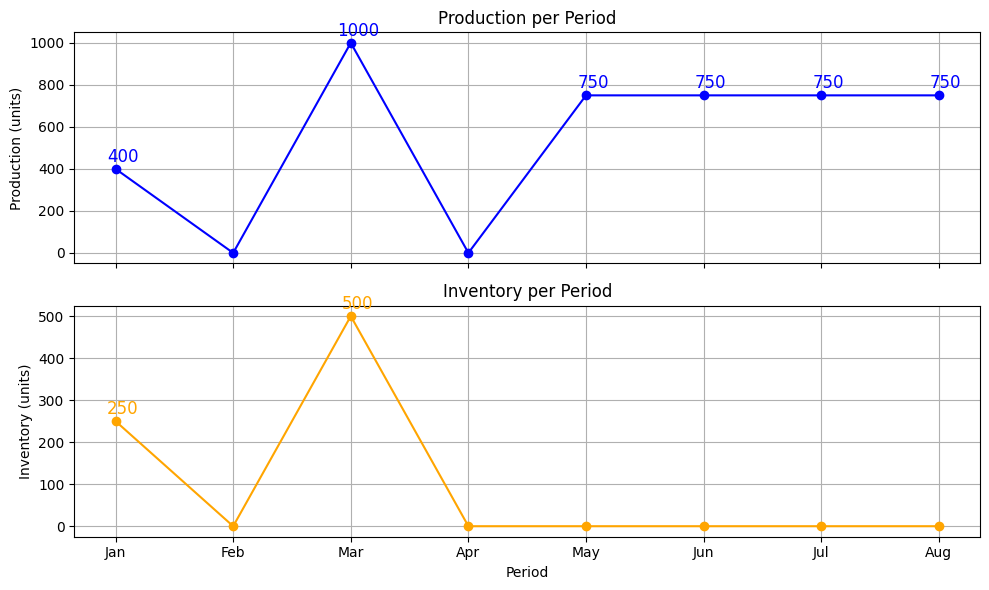

In [22]:

    # Extract production and inventory data
    periods = list(production_df.columns)  # Months
    production_values = production_df.loc["production"].tolist()
    inventory_values = production_df.loc["inventory"].tolist()

    # Create figure and axes
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 6), sharex=True)

    # Production plot
    axes[0].plot(periods, production_values, marker='o', linestyle='-', color='blue')
    axes[0].set_title("Production per Period")
    axes[0].set_ylabel("Production (units)")
    axes[0].grid(True)

    # Annotate production values
    for i, txt in enumerate(production_values):
        if txt > 0:  # Only annotate non-zero values
            axes[0].annotate(f"{int(txt)}", (periods[i], production_values[i]), textcoords="offset points", xytext=(5,5), ha='center', fontsize=12, color='blue')

    # Inventory plot
    axes[1].plot(periods, inventory_values, marker='o', linestyle='-', color='orange')
    axes[1].set_title("Inventory per Period")
    axes[1].set_ylabel("Inventory (units)")
    axes[1].set_xlabel("Period")
    axes[1].grid(True)

    # Annotate inventory values
    for i, txt in enumerate(inventory_values):
        if txt > 0:  # Only annotate non-zero values
            axes[1].annotate(f"{int(txt)}", (periods[i], inventory_values[i]), textcoords="offset points", xytext=(5,5), ha='center', fontsize=12, color='orange')

    # Display the plots
    plt.tight_layout()
    plt.show()



In [23]:
# Ejecutar modelo
data = data_generator()
PRODUCTION_PLAN = opt_production_first(data)

# 🔹 Imprimir valores antes de mostrar la tabla
print("\n📊 **Resultados de la Optimización:**")
print("Mes\tProducción\tSetup\tInventario")
for month in data.months:
    print(f"{month}\t{PRODUCTION_PLAN[month]['production']:.0f}\t\t{PRODUCTION_PLAN[month]['setup']}\t\t{PRODUCTION_PLAN[month]['inventory']:.0f}")

# 🔹 Mostrar tabla corregida
display(pd.DataFrame.from_dict(PRODUCTION_PLAN).round(0))



📊 **Resultados de la Optimización:**
Mes	Producción	Setup	Inventario
Jan	400		1		250
Feb	-0		0		0
Mar	1000		1		500
Apr	0		0		0
May	750		1		0
Jun	750		1		0
Jul	750		1		0
Aug	750		1		0


,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug
production,400.0,-0.0,1000.0,0.0,750.0,750.0,750.0,750.0
setup,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0
inventory,250.0,0.0,500.0,0.0,0.0,0.0,0.0,0.0


## Question 1

In [24]:
class data_generator_second():

  def __init__(self):
    self.setup_cost = 2000
    self.production_cost = 45
    self.first_inventory = 0
    self.inventory_cost = 3

    self.months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug']
    self.demands = [100, 150, 200, 250, 300, 350, 400, 450]

In [25]:
data = data_generator_second()
PRODUCTION_PLAN = opt_production_first(data)
display(pd.DataFrame.from_dict(PRODUCTION_PLAN).round(0))


if PRODUCTION_PLAN:
    # Cost computation dictionary
    costs = {
        "Setup Cost": [],
        "Production Cost": [],
        "Inventory Cost": [],
        "Total Cost": []
    }

    total_setup_cost = 0
    total_production_cost = 0
    total_inventory_cost = 0

    for m_idx, month in enumerate(data.months):
        setup_value = PRODUCTION_PLAN[month]['setup']
        production_value = PRODUCTION_PLAN[month]['production']
        inventory_value = PRODUCTION_PLAN[month]['inventory']

        # Use the solver's setup variable directly
        setup_cost = setup_value * data.setup_cost
        production_cost = production_value * data.production_cost
        inventory_cost = inventory_value * data.inventory_cost

        # Append costs to the dictionary
        costs["Setup Cost"].append(setup_cost)
        costs["Production Cost"].append(production_cost)
        costs["Inventory Cost"].append(inventory_cost)
        costs["Total Cost"].append(setup_cost + production_cost + inventory_cost)

        # Accumulate total costs
        total_setup_cost += setup_cost
        total_production_cost += production_cost
        total_inventory_cost += inventory_cost

    # Create a DataFrame for costs
    costs_df = pd.DataFrame(costs, index=data.months)

    # Format numerical values to two decimal places with thousands separators
    costs_df_formatted = costs_df.applymap(lambda x: f"{x:,.2f}")

    # Display the formatted DataFrame
    from IPython.display import display
    display(costs_df_formatted)

    # Display total cost breakdown
    total_cost = total_setup_cost + total_production_cost + total_inventory_cost
    print(f" Total Plan Cost: {total_cost:,.2f}")
    print(f"   - Setup Cost: {total_setup_cost:,.2f}")
    print(f"   - Production Cost: {total_production_cost:,.2f}")
    print(f"   - Inventory Cost: {total_inventory_cost:,.2f}")

else:
    print("No data available to display.")


if PRODUCTION_PLAN:
    # Convert the production plan dictionary to a DataFrame
    production_df = pd.DataFrame.from_dict(PRODUCTION_PLAN).round(0)

    # Calculate total production, total setups, and total inventory
    total_production = production_df.loc["production"].sum()
    total_setups = production_df.loc["setup"].sum()
    total_inventory = production_df.loc["inventory"].sum()

    # Display the DataFrame using Pandas
    print("\nProduction Plan DataFrame:")
    display(production_df)  # Uses Jupyter Notebook's built-in display function

    # Print summary totals
    print("\nSummary:")
    print(f"Total Units Produced: {total_production}")
    print(f"Total Number of Setups: {total_setups}")
    print(f"Total Inventory: {total_inventory}")
else:
    print("No data available to display.")


    # Extract production and inventory data
    periods = list(production_df.columns)  # Months
    production_values = production_df.loc["production"].tolist()
    inventory_values = production_df.loc["inventory"].tolist()

    # Create figure and axes
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 6), sharex=True)

    # Production plot
    axes[0].plot(periods, production_values, marker='o', linestyle='-', color='blue')
    axes[0].set_title("Production per Period")
    axes[0].set_ylabel("Production (units)")
    axes[0].grid(True)

    # Annotate production values
    for i, txt in enumerate(production_values):
        if txt > 0:  # Only annotate non-zero values
            axes[0].annotate(f"{int(txt)}", (periods[i], production_values[i]), textcoords="offset points", xytext=(5,5), ha='center', fontsize=12, color='blue')

    # Inventory plot
    axes[1].plot(periods, inventory_values, marker='o', linestyle='-', color='orange')
    axes[1].set_title("Inventory per Period")
    axes[1].set_ylabel("Inventory (units)")
    axes[1].set_xlabel("Period")
    axes[1].grid(True)

    # Annotate inventory values
    for i, txt in enumerate(inventory_values):
        if txt > 0:  # Only annotate non-zero values
            axes[1].annotate(f"{int(txt)}", (periods[i], inventory_values[i]), textcoords="offset points", xytext=(5,5), ha='center', fontsize=12, color='orange')

    # Display the plots
    plt.tight_layout()
    plt.show()


,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug
production,250.0,0.0,450.0,-0.0,650.0,0.0,850.0,0.0
setup,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
inventory,150.0,-0.0,250.0,-0.0,350.0,0.0,450.0,-0.0


<ipython-input-25-970a0b3d1edf>:44: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  costs_df_formatted = costs_df.applymap(lambda x: f"{x:,.2f}")


,Setup Cost,Production Cost,Inventory Cost,Total Cost
Jan,"2,000.00","11,250.00",450.00,"13,700.00"
Feb,0.00,0.00,-0.00,0.00
Mar,"2,000.00","20,250.00",750.00,"23,000.00"
Apr,0.00,-0.00,-0.00,-0.00
May,"2,000.00","29,250.00","1,050.00","32,300.00"
Jun,0.00,0.00,0.00,0.00
Jul,"2,000.00","38,250.00","1,350.00","41,600.00"
Aug,0.00,0.00,-0.00,0.00


 Total Plan Cost: 110,600.00
   - Setup Cost: 8,000.00
   - Production Cost: 99,000.00
   - Inventory Cost: 3,600.00

Production Plan DataFrame:


,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug
production,250.0,0.0,450.0,-0.0,650.0,0.0,850.0,0.0
setup,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
inventory,150.0,-0.0,250.0,-0.0,350.0,0.0,450.0,-0.0



Summary:
Total Units Produced: 2200.0
Total Number of Setups: 4.0
Total Inventory: 1200.0


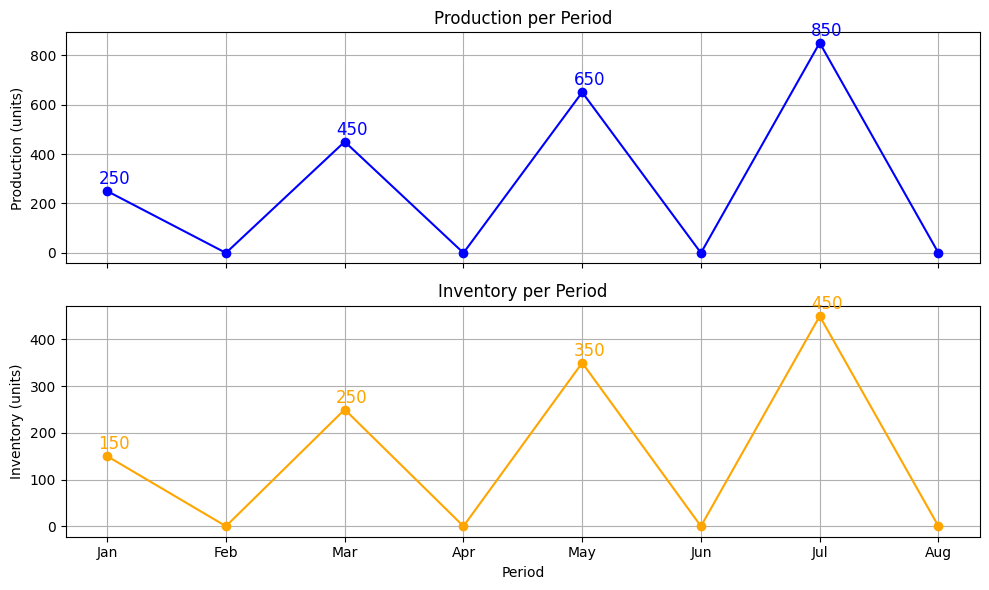

In [26]:

    # Extract production and inventory data
    periods = list(production_df.columns)  # Months
    production_values = production_df.loc["production"].tolist()
    inventory_values = production_df.loc["inventory"].tolist()

    # Create figure and axes
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 6), sharex=True)

    # Production plot
    axes[0].plot(periods, production_values, marker='o', linestyle='-', color='blue')
    axes[0].set_title("Production per Period")
    axes[0].set_ylabel("Production (units)")
    axes[0].grid(True)

    # Annotate production values
    for i, txt in enumerate(production_values):
        if txt > 0:  # Only annotate non-zero values
            axes[0].annotate(f"{int(txt)}", (periods[i], production_values[i]), textcoords="offset points", xytext=(5,5), ha='center', fontsize=12, color='blue')

    # Inventory plot
    axes[1].plot(periods, inventory_values, marker='o', linestyle='-', color='orange')
    axes[1].set_title("Inventory per Period")
    axes[1].set_ylabel("Inventory (units)")
    axes[1].set_xlabel("Period")
    axes[1].grid(True)

    # Annotate inventory values
    for i, txt in enumerate(inventory_values):
        if txt > 0:  # Only annotate non-zero values
            axes[1].annotate(f"{int(txt)}", (periods[i], inventory_values[i]), textcoords="offset points", xytext=(5,5), ha='center', fontsize=12, color='orange')

    # Display the plots
    plt.tight_layout()
    plt.show()

## Question 2

In [27]:
class data_generator_third():

  def __init__(self):
    self.setup_cost = [3500, 2000]
    self.production_cost = [75, 45]
    self.first_inventory = [100,0]
    self.inventory_cost = [5, 3]

    self.months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug']
    self.demands = [[250, 250, 500, 500, 750, 750, 750, 750], \
                    [100, 150, 200, 250, 300, 350, 400, 450]]

In [28]:
from ortools.linear_solver import pywraplp
import pandas as pd

def opt_production_third(data):

    # Create the mip solver with the SCIP backend.
    m = pywraplp.Solver.CreateSolver('SCIP')

    # Decision variables
    obj = m.NumVar(0, 1000000, 'obj')

    setup = []
    production = []
    inventory = []
    for bike in range(len(data.demands)):
        setup_temp = []
        production_temp = []
        inventory_temp = []
        for month in range(len(data.months)):
            suffix = '_{}_{}'.format(bike, month)
            setup_temp.append(m.BoolVar('setup' + suffix))
            production_temp.append(m.NumVar(0, sum(data.demands[bike]), 'production' + suffix))
            inventory_temp.append(m.NumVar(0, sum(data.demands[bike]), 'inventory' + suffix))

        setup.append(setup_temp)
        production.append(production_temp)
        inventory.append(inventory_temp)

    # Constraints
    for bike in range(len(data.demands)):
        # **First-Month Inventory Balance Constraint**
        m.Add(data.first_inventory[bike] + production[bike][0] == data.demands[bike][0] + inventory[bike][0])

        # 🔹 **Force setup = 1 in the first month if production occurs**
        m.Add(setup[bike][0] >= production[bike][0] / sum(data.demands[bike]))

        for month in range(1, len(data.months)):
            # **Setup constraint**
            m.Add(production[bike][month] <= sum(data.demands[bike][month:]) * setup[bike][month])

            # **Flow conservation constraint**
            m.Add(inventory[bike][month-1] + production[bike][month] == data.demands[bike][month] + inventory[bike][month])

    # Objective function constraint
    m.Add(obj >= sum(
        sum(setup[bike]) * data.setup_cost[bike] + \
        sum(production[bike]) * data.production_cost[bike] + \
        sum(inventory[bike][:-1]) * data.inventory_cost[bike] + \
        inventory[bike][-1] * data.inventory_cost[bike] / 2
        for bike in range(len(data.demands))
    ))

    # Minimize objective
    m.Minimize(obj)

    # Solve the model
    status = m.Solve()

    if status == pywraplp.Solver.OPTIMAL:
        PRODUCTION_PLAN = {}
        for bike in range(len(data.demands)):
            PRODUCTION_PLAN_temp = {}
            for m_idx, month in enumerate(data.months):
                PRODUCTION_PLAN_temp[month] = {
                    'production': production[bike][m_idx].solution_value(),
                    'setup': round(setup[bike][m_idx].solution_value()),  # Round setup to ensure it's 0 or 1
                    'inventory': inventory[bike][m_idx].solution_value()
                }
            PRODUCTION_PLAN[bike] = PRODUCTION_PLAN_temp
        return PRODUCTION_PLAN, obj.solution_value()

    else:
        print('The problem does not have an optimal solution.')
        return None, None

# Run the function
data = data_generator_third()
PRODUCTION_PLAN, obj = opt_production_third(data)

if PRODUCTION_PLAN:
    display(pd.DataFrame.from_dict(PRODUCTION_PLAN[0]).round(2))
    display(pd.DataFrame.from_dict(PRODUCTION_PLAN[1]).round(2))
    print('Objective is:', round(obj, 2))


,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug
production,400.0,0.0,1000.0,0.0,750.0,750.0,750.0,750.0
setup,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0
inventory,250.0,0.0,500.0,0.0,0.0,0.0,0.0,0.0


,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug
production,250.0,0.0,450.0,0.0,650.0,0.0,850.0,0.0
setup,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
inventory,150.0,0.0,250.0,0.0,350.0,0.0,450.0,0.0


Objective is: 465350.0


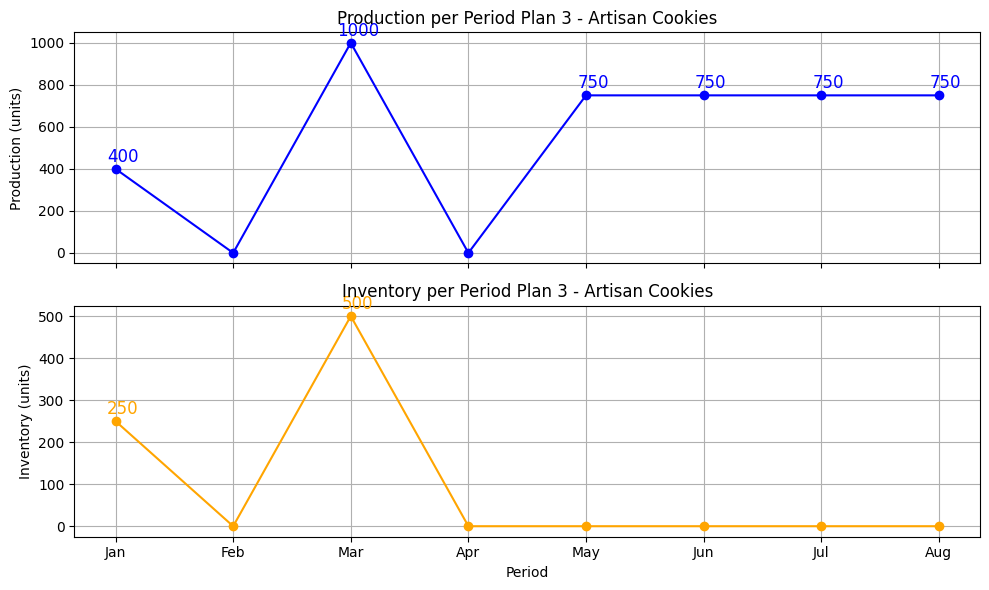

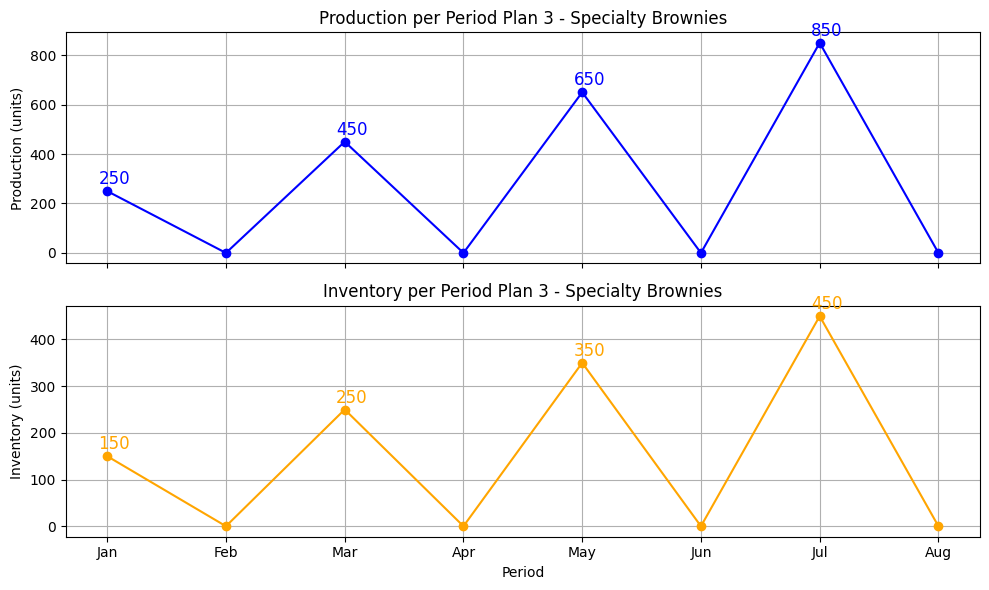


Production Plan DataFrame for Artisan Cookies:


,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug
production,400.0,0.0,1000.0,0.0,750.0,750.0,750.0,750.0
setup,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0
inventory,250.0,0.0,500.0,0.0,0.0,0.0,0.0,0.0



Cost Summary for Artisan Cookies:
Total Setup Cost: 21000.0
Total Production Cost: 330000.0
Total Inventory Cost: 3750.0
Total Cost: 354750.0

Production Plan DataFrame for Specialty Brownies:


,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug
production,250.0,0.0,450.0,0.0,650.0,0.0,850.0,0.0
setup,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
inventory,150.0,0.0,250.0,0.0,350.0,0.0,450.0,0.0



Cost Summary for Specialty Brownies:
Total Setup Cost: 8000.0
Total Production Cost: 99000.0
Total Inventory Cost: 3600.0
Total Cost: 110600.0


In [29]:

# Ensure PRODUCTION_PLAN is defined by running the optimization function
data = data_generator_third()
PRODUCTION_PLAN, obj = opt_production_third(data)

# Function to calculate and display costs for both plans
def calculate_and_display_costs(PRODUCTION_PLAN, data):
    product_labels = {0: "Artisan Cookies", 1: "Specialty Brownies"}

    for bike in PRODUCTION_PLAN.keys():
        plan_df = pd.DataFrame.from_dict(PRODUCTION_PLAN[bike]).round(0)

        # Calculate total costs
        total_setup_cost = plan_df.loc["setup"].sum() * data.setup_cost[bike]
        total_production_cost = plan_df.loc["production"].sum() * data.production_cost[bike]
        total_inventory_cost = plan_df.loc["inventory"].sum() * data.inventory_cost[bike]
        total_cost = total_setup_cost + total_production_cost + total_inventory_cost

        # Display DataFrame
        print(f"\nProduction Plan DataFrame for {product_labels[bike]}:")
        display(plan_df)

        # Print cost summary
        print(f"\nCost Summary for {product_labels[bike]}:")
        print(f"Total Setup Cost: {total_setup_cost}")
        print(f"Total Production Cost: {total_production_cost}")
        print(f"Total Inventory Cost: {total_inventory_cost}")
        print(f"Total Cost: {total_cost}")

# Function to plot production and inventory with custom labels
def plot_production_inventory(PRODUCTION_PLAN, title_suffix=""):
    product_labels = {0: "Artisan Cookies", 1: "Specialty Brownies"}

    for bike in PRODUCTION_PLAN.keys():
        plan_df = pd.DataFrame.from_dict(PRODUCTION_PLAN[bike]).round(0)

        # Extract production and inventory data
        periods = list(plan_df.columns)
        production_values = plan_df.loc["production"].tolist()
        inventory_values = plan_df.loc["inventory"].tolist()

        # Create figure and axes
        fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 6), sharex=True)

        # Production plot
        axes[0].plot(periods, production_values, marker='o', linestyle='-', color='blue')
        axes[0].set_title(f"Production per Period {title_suffix} - {product_labels[bike]}")
        axes[0].set_ylabel("Production (units)")
        axes[0].grid(True)

        for i, txt in enumerate(production_values):
            if txt > 0:
                axes[0].annotate(f"{int(txt)}", (periods[i], production_values[i]),
                                 textcoords="offset points", xytext=(5,5), ha='center', fontsize=12, color='blue')

        # Inventory plot
        axes[1].plot(periods, inventory_values, marker='o', linestyle='-', color='orange')
        axes[1].set_title(f"Inventory per Period {title_suffix} - {product_labels[bike]}")
        axes[1].set_ylabel("Inventory (units)")
        axes[1].set_xlabel("Period")
        axes[1].grid(True)

        for i, txt in enumerate(inventory_values):
            if txt > 0:
                axes[1].annotate(f"{int(txt)}", (periods[i], inventory_values[i]),
                                 textcoords="offset points", xytext=(5,5), ha='center', fontsize=12, color='orange')

        plt.tight_layout()
        plt.show()

# Run the function and plot the results with custom labels
if PRODUCTION_PLAN:
    plot_production_inventory(PRODUCTION_PLAN, title_suffix="Plan 3")
    calculate_and_display_costs(PRODUCTION_PLAN, data)
else:
    print("No data available to plot or display costs.")



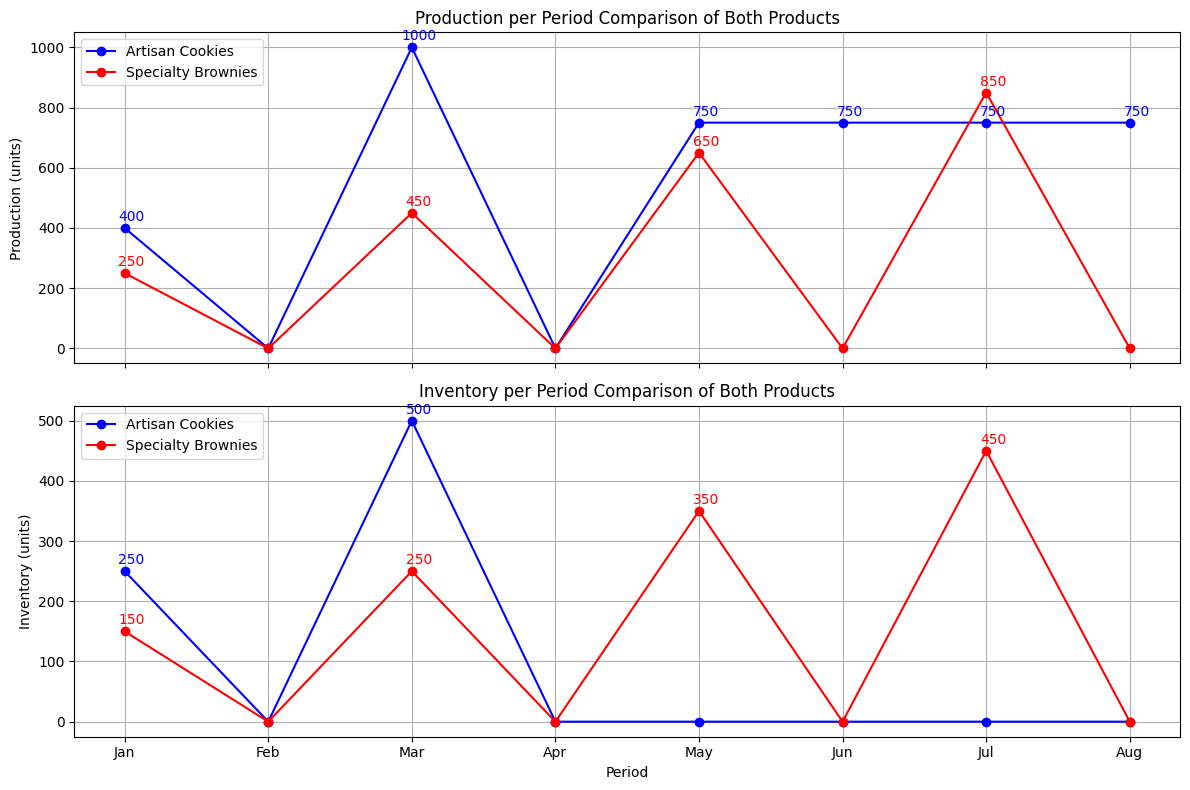

In [30]:
# Function to plot both plans together with custom labels
def plot_both_plans(PRODUCTION_PLAN, title_suffix=""):
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 8), sharex=True)

    # Assign custom labels for products
    product_labels = {0: "Artisan Cookies", 1: "Specialty Brownies"}
    colors = ['blue', 'red']  # Colors for different products

    for bike, color in zip(PRODUCTION_PLAN.keys(), colors):
        plan_df = pd.DataFrame.from_dict(PRODUCTION_PLAN[bike]).round(0)

        # Extract production and inventory data
        periods = list(plan_df.columns)
        production_values = plan_df.loc["production"].tolist()
        inventory_values = plan_df.loc["inventory"].tolist()

        # Production plot
        axes[0].plot(periods, production_values, marker='o', linestyle='-', color=color, label=product_labels[bike])
        for i, txt in enumerate(production_values):
            if txt > 0:
                axes[0].annotate(f"{int(txt)}", (periods[i], production_values[i]),
                                 textcoords="offset points", xytext=(5,5), ha='center', fontsize=10, color=color)

        # Inventory plot
        axes[1].plot(periods, inventory_values, marker='o', linestyle='-', color=color, label=product_labels[bike])
        for i, txt in enumerate(inventory_values):
            if txt > 0:
                axes[1].annotate(f"{int(txt)}", (periods[i], inventory_values[i]),
                                 textcoords="offset points", xytext=(5,5), ha='center', fontsize=10, color=color)

    # Customize production plot
    axes[0].set_title(f"Production per Period {title_suffix}")
    axes[0].set_ylabel("Production (units)")
    axes[0].grid(True)
    axes[0].legend()

    # Customize inventory plot
    axes[1].set_title(f"Inventory per Period {title_suffix}")
    axes[1].set_ylabel("Inventory (units)")
    axes[1].set_xlabel("Period")
    axes[1].grid(True)
    axes[1].legend()

    # Show the plots
    plt.tight_layout()
    plt.show()

# Run the function and plot both plans together
if PRODUCTION_PLAN:
    plot_both_plans(PRODUCTION_PLAN, title_suffix="Comparison of Both Products")
else:
    print("No data available to plot.")



Total Cost Summary for the Entire Plant:
Total Setup Cost: 29000.0
Total Production Cost: 429000.0
Total Inventory Cost: 7350.0
Total Cost: 465350.0


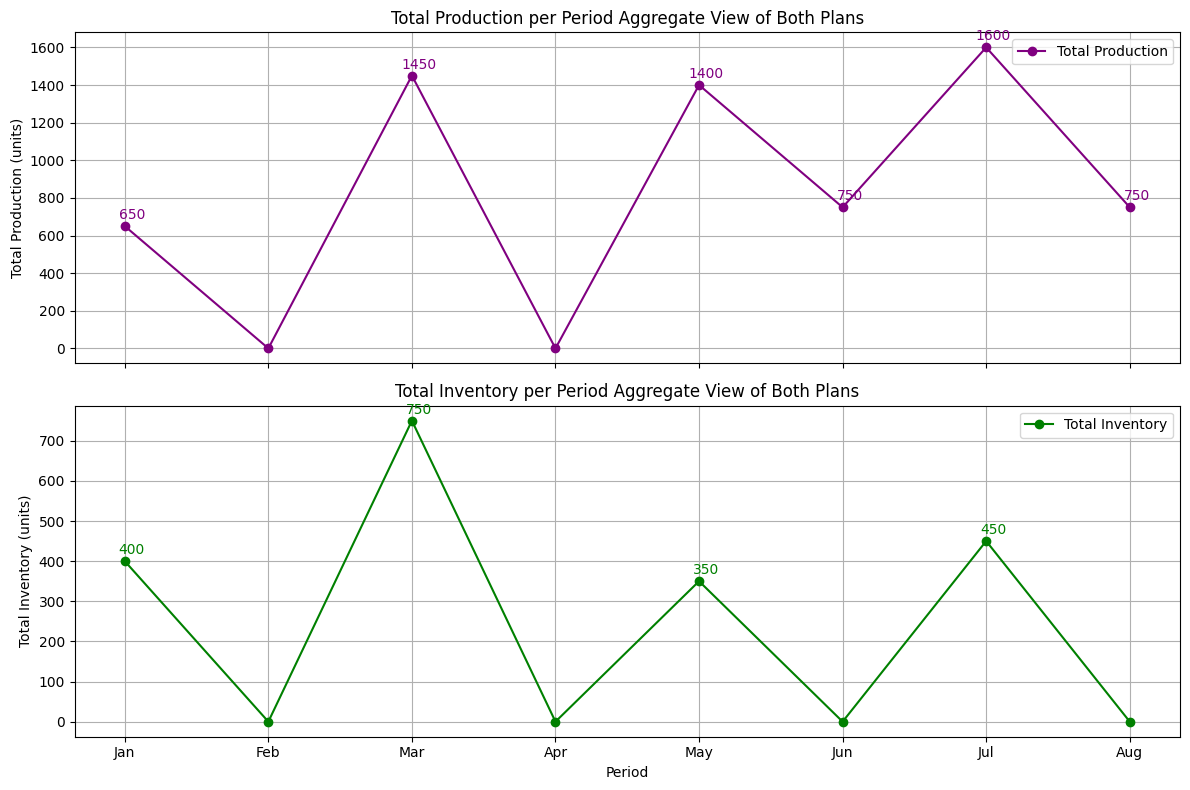

In [31]:
# Function to calculate total costs for all plans
def calculate_total_costs(PRODUCTION_PLAN, data):
    total_setup_cost = 0
    total_production_cost = 0
    total_inventory_cost = 0

    for bike in PRODUCTION_PLAN.keys():
        plan_df = pd.DataFrame.from_dict(PRODUCTION_PLAN[bike]).round(0)

        # Sum up costs for all bikes
        total_setup_cost += plan_df.loc["setup"].sum() * data.setup_cost[bike]
        total_production_cost += plan_df.loc["production"].sum() * data.production_cost[bike]
        total_inventory_cost += plan_df.loc["inventory"].sum() * data.inventory_cost[bike]

    total_cost = total_setup_cost + total_production_cost + total_inventory_cost

    # Print cost summary
    print("\nTotal Cost Summary for the Entire Plant:")
    print(f"Total Setup Cost: {total_setup_cost}")
    print(f"Total Production Cost: {total_production_cost}")
    print(f"Total Inventory Cost: {total_inventory_cost}")
    print(f"Total Cost: {total_cost}")

# Function to plot total production and inventory for all plans
def plot_total_production_inventory(PRODUCTION_PLAN, title_suffix=""):
    total_production_values = None
    total_inventory_values = None
    periods = list(pd.DataFrame.from_dict(PRODUCTION_PLAN[0]).columns)

    for bike in PRODUCTION_PLAN.keys():
        plan_df = pd.DataFrame.from_dict(PRODUCTION_PLAN[bike]).round(0)

        if total_production_values is None:
            total_production_values = plan_df.loc["production"].tolist()
            total_inventory_values = plan_df.loc["inventory"].tolist()
        else:
            total_production_values = [sum(x) for x in zip(total_production_values, plan_df.loc["production"].tolist())]
            total_inventory_values = [sum(x) for x in zip(total_inventory_values, plan_df.loc["inventory"].tolist())]

    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 8), sharex=True)

    # Total Production plot
    axes[0].plot(periods, total_production_values, marker='o', linestyle='-', color='purple', label='Total Production')
    for i, txt in enumerate(total_production_values):
        if txt > 0:
            axes[0].annotate(f"{int(txt)}", (periods[i], total_production_values[i]),
                             textcoords="offset points", xytext=(5,5), ha='center', fontsize=10, color='purple')
    axes[0].set_title(f"Total Production per Period {title_suffix}")
    axes[0].set_ylabel("Total Production (units)")
    axes[0].grid(True)
    axes[0].legend()

    # Total Inventory plot
    axes[1].plot(periods, total_inventory_values, marker='o', linestyle='-', color='green', label='Total Inventory')
    for i, txt in enumerate(total_inventory_values):
        if txt > 0:
            axes[1].annotate(f"{int(txt)}", (periods[i], total_inventory_values[i]),
                             textcoords="offset points", xytext=(5,5), ha='center', fontsize=10, color='green')
    axes[1].set_title(f"Total Inventory per Period {title_suffix}")
    axes[1].set_ylabel("Total Inventory (units)")
    axes[1].set_xlabel("Period")
    axes[1].grid(True)
    axes[1].legend()

    plt.tight_layout()
    plt.show()

# Run the function to calculate total costs and plot total production/inventory
if PRODUCTION_PLAN:
    calculate_total_costs(PRODUCTION_PLAN, data)
    plot_total_production_inventory(PRODUCTION_PLAN, title_suffix="Aggregate View of Both Plans")
else:
    print("No data available to compute totals or plot.")


## Question 3

In [32]:
from ortools.linear_solver import pywraplp
import pandas as pd

def opt_production_third(data):

    # Create the mip solver with the SCIP backend.
    m = pywraplp.Solver.CreateSolver('SCIP')

    # Decision variables
    obj = m.NumVar(0, 1000000, 'obj')

    setup = []
    production = []
    inventory = []
    for bike in range(len(data.demands)):
        setup_temp = []
        production_temp = []
        inventory_temp = []
        for month in range(len(data.months)):
            suffix = '_{}_{}'.format(bike, month)
            setup_temp.append(m.BoolVar('setup' + suffix))
            production_temp.append(m.NumVar(0, sum(data.demands[bike]), 'production' + suffix))
            inventory_temp.append(m.NumVar(0, sum(data.demands[bike]), 'inventory' + suffix))

        setup.append(setup_temp)
        production.append(production_temp)
        inventory.append(inventory_temp)

    # Objective function constraint
    m.Add(obj >= sum(
        sum(setup[bike]) * data.setup_cost[bike] +
        sum(production[bike]) * data.production_cost[bike] +
        sum(inventory[bike][:-1]) * data.inventory_cost[bike] +
        inventory[bike][-1] * data.inventory_cost[bike] / 2
        for bike in range(len(data.demands))
    ))

    # Constraints
    for bike in range(len(data.demands)):
        # **First-Month Inventory Balance Constraint**
        m.Add(data.first_inventory[bike] + production[bike][0] == data.demands[bike][0] + inventory[bike][0])

        # 🔹 **Force setup = 1 in the first month if production occurs**
        m.Add(setup[bike][0] >= production[bike][0] / sum(data.demands[bike]))

        for month in range(1, len(data.months)):
            # **Setup constraint**
            m.Add(production[bike][month] <= sum(data.demands[bike][month:]) * setup[bike][month])

            # **Flow conservation constraint**
            m.Add(inventory[bike][month-1] + production[bike][month] == data.demands[bike][month] + inventory[bike][month])

    # **Total production limit per month**
    for month in range(1, len(data.months)):
        m.Add(sum(production[bike][month] for bike in range(len(data.demands))) <= 1000)

    # Minimize objective
    m.Minimize(obj)

    # Solve the model
    status = m.Solve()

    if status == pywraplp.Solver.OPTIMAL:
        PRODUCTION_PLAN = {}
        for bike in range(len(data.demands)):
            PRODUCTION_PLAN_temp = {}
            for m_idx, month in enumerate(data.months):
                PRODUCTION_PLAN_temp[month] = {
                    'production': production[bike][m_idx].solution_value(),
                    'setup': round(setup[bike][m_idx].solution_value()),  # Round setup to ensure it's 0 or 1
                    'inventory': inventory[bike][m_idx].solution_value()
                }
            PRODUCTION_PLAN[bike] = PRODUCTION_PLAN_temp
        return PRODUCTION_PLAN, obj.solution_value()

    else:
        print('The problem does not have an optimal solution.')
        return None, None

# Run the function
data = data_generator_third()
PRODUCTION_PLAN, obj = opt_production_third(data)

if PRODUCTION_PLAN:
    display(pd.DataFrame.from_dict(PRODUCTION_PLAN[0]).round(2))
    display(pd.DataFrame.from_dict(PRODUCTION_PLAN[1]).round(2))
    print('Objective is:', round(obj, 2))


,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug
production,400.0,-0.0,1000.0,0.0,750.0,1000.0,500.0,750.0
setup,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0
inventory,250.0,0.0,500.0,0.0,0.0,250.0,0.0,0.0


,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug
production,450.0,0.0,0.0,1000.0,-0.0,0.0,500.0,250.0
setup,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0
inventory,350.0,200.0,0.0,750.0,450.0,100.0,200.0,0.0


Objective is: 469150.0



Total Cost Summary for the Entire Plant:
Total Setup Cost: 29000.0
Total Production Cost: 429000.0
Total Inventory Cost: 11150.0
Total Cost: 469150.0


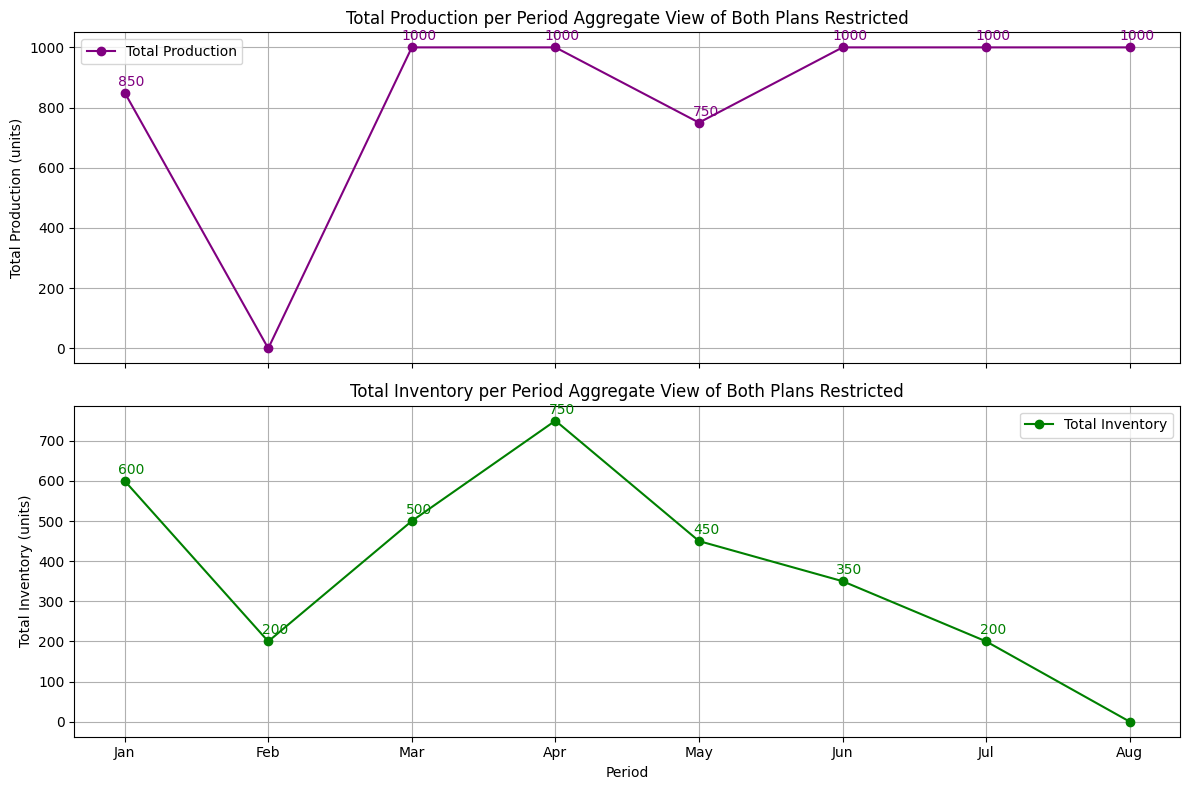

In [33]:
# Function to calculate total costs for all plans
def calculate_total_costs(PRODUCTION_PLAN, data):
    total_setup_cost = 0
    total_production_cost = 0
    total_inventory_cost = 0

    for bike in PRODUCTION_PLAN.keys():
        plan_df = pd.DataFrame.from_dict(PRODUCTION_PLAN[bike]).round(0)

        # Sum up costs for all bikes
        total_setup_cost += plan_df.loc["setup"].sum() * data.setup_cost[bike]
        total_production_cost += plan_df.loc["production"].sum() * data.production_cost[bike]
        total_inventory_cost += plan_df.loc["inventory"].sum() * data.inventory_cost[bike]

    total_cost = total_setup_cost + total_production_cost + total_inventory_cost

    # Print cost summary
    print("\nTotal Cost Summary for the Entire Plant:")
    print(f"Total Setup Cost: {total_setup_cost}")
    print(f"Total Production Cost: {total_production_cost}")
    print(f"Total Inventory Cost: {total_inventory_cost}")
    print(f"Total Cost: {total_cost}")

# Function to plot total production and inventory for all plans
def plot_total_production_inventory(PRODUCTION_PLAN, title_suffix=""):
    total_production_values = None
    total_inventory_values = None
    periods = list(pd.DataFrame.from_dict(PRODUCTION_PLAN[0]).columns)

    for bike in PRODUCTION_PLAN.keys():
        plan_df = pd.DataFrame.from_dict(PRODUCTION_PLAN[bike]).round(0)

        if total_production_values is None:
            total_production_values = plan_df.loc["production"].tolist()
            total_inventory_values = plan_df.loc["inventory"].tolist()
        else:
            total_production_values = [sum(x) for x in zip(total_production_values, plan_df.loc["production"].tolist())]
            total_inventory_values = [sum(x) for x in zip(total_inventory_values, plan_df.loc["inventory"].tolist())]

    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 8), sharex=True)

    # Total Production plot
    axes[0].plot(periods, total_production_values, marker='o', linestyle='-', color='purple', label='Total Production')
    for i, txt in enumerate(total_production_values):
        if txt > 0:
            axes[0].annotate(f"{int(txt)}", (periods[i], total_production_values[i]),
                             textcoords="offset points", xytext=(5,5), ha='center', fontsize=10, color='purple')
    axes[0].set_title(f"Total Production per Period {title_suffix}")
    axes[0].set_ylabel("Total Production (units)")
    axes[0].grid(True)
    axes[0].legend()

    # Total Inventory plot
    axes[1].plot(periods, total_inventory_values, marker='o', linestyle='-', color='green', label='Total Inventory')
    for i, txt in enumerate(total_inventory_values):
        if txt > 0:
            axes[1].annotate(f"{int(txt)}", (periods[i], total_inventory_values[i]),
                             textcoords="offset points", xytext=(5,5), ha='center', fontsize=10, color='green')
    axes[1].set_title(f"Total Inventory per Period {title_suffix}")
    axes[1].set_ylabel("Total Inventory (units)")
    axes[1].set_xlabel("Period")
    axes[1].grid(True)
    axes[1].legend()

    plt.tight_layout()
    plt.show()

# Run the function to calculate total costs and plot total production/inventory
if PRODUCTION_PLAN:
    calculate_total_costs(PRODUCTION_PLAN, data)
    plot_total_production_inventory(PRODUCTION_PLAN, title_suffix="Aggregate View of Both Plans Restricted")
else:
    print("No data available to compute totals or plot.")
